In [1]:
from __future__ import print_function #Python 2.7 compatibility
from srwlib import *
from srwl_uti_smp import *
from uti_plot import * #required for plotting
import copy, os, sys, time
import numpy as np
import pylab as plt

In [2]:
#**********************Input Parameters and Structures
#***********Folder and Data File Names
strDataFolderName = 'data_demo' #data sub-folder name
strIntInitOutFileName01 = 'demo_res_int_in.dat' #initial wavefront intensity distribution output file name
strIntPropOutFileName01 = 'demo_res_int_after_CRL0.dat' #propagated wavefront intensity distribution output file name
strIntPropOutFileName02 = 'demo_res_int_after_C1.dat'

#***********Gaussian Beam Source
GsnBm = SRWLGsnBm() #Gaussian Beam structure (just parameters)
GsnBm.x = 0 #Transverse Positions of Gaussian Beam Center at Waist [m]
GsnBm.y = 0
GsnBm.z = 630. #Longitudinal Position of Waist [m]
GsnBm.xp = 0 #Average Angles of Gaussian Beam at Waist [rad]
GsnBm.yp = 0
GsnBm.avgPhotEn = 9481 #Photon Energy [eV]
GsnBm.pulseEn = 0.001 #Energy per Pulse [J] - to be corrected
GsnBm.repRate = 1 #Rep. Rate [Hz] - to be corrected
GsnBm.polar = 1 #1- linear horizontal
GsnBm.sigX = 23.e-6/2.35 #Horiz. RMS size at Waist [m]
GsnBm.sigY = GsnBm.sigX #Vert. RMS size at Waist [m]

constConvRad = 1.23984186e-06/(4*3.1415926536)
rmsAngDiv = constConvRad/(GsnBm.avgPhotEn*GsnBm.sigX) #RMS angular divergence [rad]
print('RMS Source Size:', round(GsnBm.sigX*1.e+06, 3), 'um; RMS Divergence:', round(rmsAngDiv*1.e+06, 3), 'urad')

GsnBm.sigT = 400e-15 #Pulse duration [fs] (not used?)
GsnBm.mx = 0 #Transverse Gauss-Hermite Mode Orders
GsnBm.my = 0

#***********Initial Wavefront
wfr = SRWLWfr() #Initial Electric Field Wavefront
wfr.allocate(1, 100, 100) #Numbers of points vs Photon Energy (1), Horizontal and Vertical Positions (dummy)
wfr.mesh.zStart = GsnBm.z + 290. #Longitudinal Position [m] at which initial Electric Field has to be calculated, i.e. the position of the first optical element
wfr.mesh.eStart = GsnBm.avgPhotEn #Initial Photon Energy [eV]
wfr.mesh.eFin = GsnBm.avgPhotEn #Final Photon Energy [eV]
wfr.unitElFld = 1 #Electric field units: 0- arbitrary, 1- sqrt(Phot/s/0.1%bw/mm^2), 2- sqrt(J/eV/mm^2) or sqrt(W/mm^2), depending on representation (freq. or time)

#Horizontal and Vertical Position Range for the Initial Wavefront calculation
firstHorAp = 3e-3 #[m]
firstVertAp = firstHorAp #[m]
wfr.mesh.xStart = -0.5*firstHorAp #Initial Horizontal Position [m]
wfr.mesh.xFin = 0.5*firstHorAp #Final Horizontal Position [m]
wfr.mesh.yStart = -0.5*firstVertAp #Initial Vertical Position [m]
wfr.mesh.yFin = 0.5*firstVertAp #Final Vertical Position [m]

sampFactNxNyForProp = 3 #sampling factor for adjusting nx, ny (effective if > 0)
arPrecPar = [sampFactNxNyForProp]

wfr.partBeam.partStatMom1.x = GsnBm.x #Some information about the source in the Wavefront structure
wfr.partBeam.partStatMom1.y = GsnBm.y
wfr.partBeam.partStatMom1.z = GsnBm.z
wfr.partBeam.partStatMom1.xp = GsnBm.xp
wfr.partBeam.partStatMom1.yp = GsnBm.yp

#***********Detector
npx = 80 #Detector Number of Pixels in Horizontal direction
npy = 80 #Detector Number of Pixels in Vertical direction
pSize = 50e-06 #Detector Pizel Size
xrDet = npx*pSize
yrDet = npy*pSize
det = SRWLDet(_xStart = -0.5*xrDet, _xFin = 0.5*xrDet, _nx = npx, _yStart = -0.5*yrDet, _yFin = 0.5*yrDet, _ny = npy)

#***********Optics
opCRL0 = srwl_opt_setup_CRL(_foc_plane=3, _delta=3.79122634e-06, _atten_len=0.01675923,
                          _shape=1, _apert_h=2e-3, _apert_v=2e-3,
                          _r_min=2.1989112772e-3, _n=1, _wall_thick=5e-5,
                          _xc=0.0, _yc=0.0, _e_start=wfr.mesh.eStart, _e_fin=wfr.mesh.eFin,
                          _nx=1001, _ny=1001)

opC1 = SRWLOptCryst(_d_sp=0.9600687344008111,
                  _psi0r=-1.0873035035585694e-05, _psi0i=1.8438837339536554e-07,
                  _psi_hr=-4.181686438547451e-06, _psi_hi=1.6100412693351052e-07,
                  _psi_hbr=-4.181686438547451e-06, _psi_hbi=1.6100412693351052e-07,
                  _tc=0.01, _ang_as=0,
                  _nvx=-0.7322282430733594, _nvy=4.975415277322606e-09, _nvz=-0.6810593219725439,
                  _tvx=-0.6810593219725439, _tvy=4.627727743855522e-09, _uc=1)


#nvx, nvy, nvz = opC1.find_orient(GsnBm.avgPhotEn,np.pi/2)[0][2]
#tvx, tvy, _ = opC1.find_orient(GsnBm.avgPhotEn,np.pi/2)[0][0]
#opC1.set_orient(nvx,nvy,nvz,tvx,tvy)

#Drift
opCRL0_Det = SRWLOptD(.1)
opCRL0_C1 = SRWLOptD(10.)
opC1_Det = SRWLOptD(.1)

#Wavefront Propagation Parameters:
#[0]: Auto-Resize (1) or not (0) Before propagation
#[1]: Auto-Resize (1) or not (0) After propagation
#[2]: Relative Precision for propagation with Auto-Resizing (1. is nominal)
#[3]: Allow (1) or not (0) for semi-analytical treatment of the quadratic (leading) phase terms at the propagation
#[4]: Do any Resizing on Fourier side, using FFT, (1) or not (0)
#[5]: Horizontal Range modification factor at Resizing (1. means no modification)
#[6]: Horizontal Resolution modification factor at Resizing
#[7]: Vertical Range modification factor at Resizing
#[8]: Vertical Resolution modification factor at Resizing
#[9]: Type of wavefront Shift before Resizing
#[10]: New Horizontal wavefront Center position after Shift
#[11]: New Vertical wavefront Center position after Shift

#             [0][1][2] [3][4] [5]  [6]  [7]  [8]  [9] [10] [11]
ppCRL0 =      [0, 0, 1., 0, 0, 4.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0]
ppCRL0_Det =  [0, 0, 1., 1, 0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0]
ppCRL0_C1 =   [0, 0, 1., 1, 0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0]
ppC1 =        [0, 0, 1., 0, 0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0]
ppC1_Det =    [0, 0, 1., 1, 0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0]
ppFin =       [0, 0, 1., 0, 0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0]


opBL1 = SRWLOptC([opCRL0, opCRL0_Det],
                 [ppCRL0, ppCRL0_Det, ppFin])
opBL2 = SRWLOptC([opCRL0, opCRL0_C1, opC1, opC1_Det],
                 [ppCRL0, ppCRL0_C1, ppC1, ppC1_Det, ppFin])


RMS Source Size: 9.787 um; RMS Divergence: 1.063 urad
Optical Element Setup: CRL Focal Length: 290.0 m


   Propagating wavefront ... done in 1 s
   Extracting, projecting propagated wavefront intensity on detector and saving it to file ... done in 0 s
   Propagating wavefront ... done in 4 s
   Extracting, projecting propagated wavefront intensity on detector and saving it to file ... done in 0 s
   Plotting the results (blocks script execution; close any graph windows to proceed) ... 

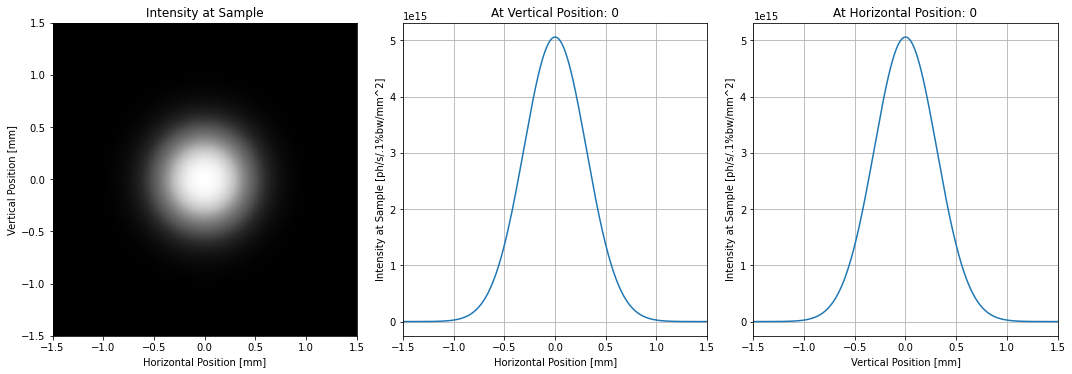

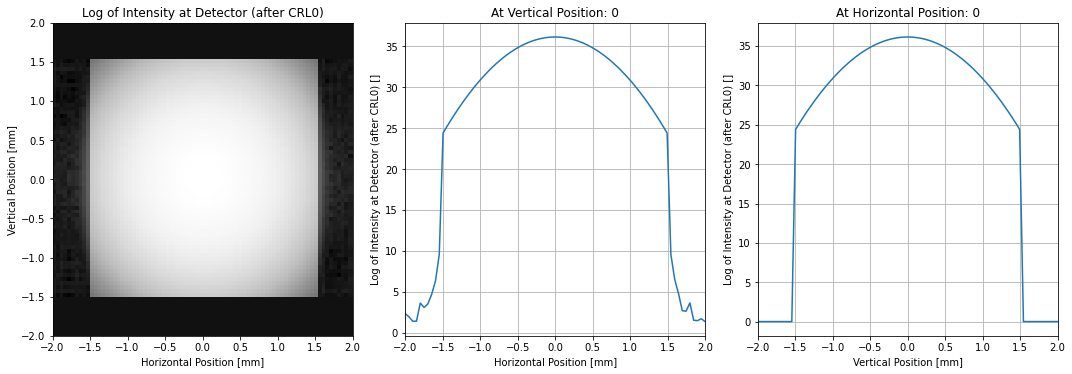

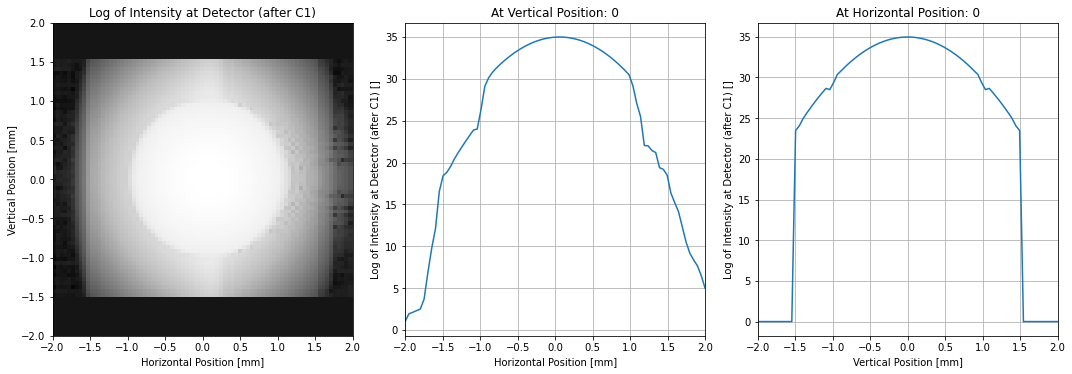

done


In [3]:
#**********************Main Calculations
#***********Initial Wavefront of Gaussian Beam
srwl.CalcElecFieldGaussian(wfr, GsnBm, arPrecPar)
mesh0 = deepcopy(wfr.mesh)
arI0 = array('f', [0]*mesh0.nx*mesh0.ny) #"flat" array to take 2D intensity data
srwl.CalcIntFromElecField(arI0, wfr, 6, 0, 3, mesh0.eStart, 0, 0) #extracts intensity

srwl_uti_save_intens_ascii(
    arI0, mesh0, os.path.join(os.getcwd(), strDataFolderName, strIntInitOutFileName01), 0,
    ['Photon Energy', 'Horizontal Position', 'Vertical Position', 'Intensity'], _arUnits=['eV', 'm', 'm', 'ph/s/.1%bw/mm^2'])

#***********Wavefront Propagation (BL1)
wfr1 = deepcopy(wfr)

print('   Propagating wavefront ... ', end='')
t = time.time()
srwl.PropagElecField(wfr1, opBL1)
print('done in', round(time.time() - t), 's')

print('   Extracting, projecting propagated wavefront intensity on detector and saving it to file ... ', end='')
t = time.time()
mesh1 = deepcopy(wfr1.mesh)
arI1 = array('f', [0]*mesh1.nx*mesh1.ny) #"flat" array to take 2D intensity data
srwl.CalcIntFromElecField(arI1, wfr1, 6, 0, 3, mesh1.eStart, 0, 0) #extracts intensity

stkDet = det.treat_int(arI1, _mesh = mesh1) #"Projecting" intensity on detector (by interpolation)
mesh1 = stkDet.mesh; arI1 = stkDet.arS
srwl_uti_save_intens_ascii(
    arI1, mesh1, os.path.join(os.getcwd(), strDataFolderName, strIntPropOutFileName01), 0,
    ['Photon Energy', 'Horizontal Position', 'Vertical Position', 'Spectral Fluence'], _arUnits=['eV', 'm', 'm', 'J/eV/mm^2'])
print('done in', round(time.time() - t), 's')

#***********Wavefront Propagation (BL2)
wfr2 = deepcopy(wfr)

print('   Propagating wavefront ... ', end='')
t = time.time()
srwl.PropagElecField(wfr2, opBL2)
print('done in', round(time.time() - t), 's')

print('   Extracting, projecting propagated wavefront intensity on detector and saving it to file ... ', end='')
t = time.time()
mesh2 = deepcopy(wfr2.mesh)
arI2 = array('f', [0]*mesh2.nx*mesh2.ny) #"flat" array to take 2D intensity data
srwl.CalcIntFromElecField(arI2, wfr2, 6, 0, 3, mesh2.eStart, 0, 0) #extracts intensity

stkDet = det.treat_int(arI2, _mesh = mesh2) #"Projecting" intensity on detector (by interpolation)
mesh2 = stkDet.mesh; arI2 = stkDet.arS
srwl_uti_save_intens_ascii(
    arI2, mesh2, os.path.join(os.getcwd(), strDataFolderName, strIntPropOutFileName02), 0,
    ['Photon Energy', 'Horizontal Position', 'Vertical Position', 'Spectral Fluence'], _arUnits=['eV', 'm', 'm', 'J/eV/mm^2'])
print('done in', round(time.time() - t), 's')

#**********************Plotting Results (requires 3rd party graphics package)
print('   Plotting the results (blocks script execution; close any graph windows to proceed) ... ', end='')
plotMesh0x = [mesh0.xStart, mesh0.xFin, mesh0.nx]
plotMesh0y = [mesh0.yStart, mesh0.yFin, mesh0.ny]
uti_plot2d1d(arI0, plotMesh0x, plotMesh0y, x=0, y=0, labels=['Horizontal Position', 'Vertical Position', 'Intensity at Sample'], units=['m', 'm', 'ph/s/.1%bw/mm^2'])

plotMesh1x = [mesh1.xStart, mesh1.xFin, mesh1.nx]
plotMesh1y = [mesh1.yStart, mesh1.yFin, mesh1.ny]
arLogI1 = copy.copy(arI1)
nTot1 = mesh1.ne*mesh1.nx*mesh1.ny
for i in range(nTot1):
    curI = arI1[i]
    if(curI <= 0.): arLogI1[i] = 0
    else: arLogI1[i] = log(curI)
uti_plot2d1d(arLogI1, plotMesh1x, plotMesh1y, x=0, y=0, labels=['Horizontal Position', 'Vertical Position', 'Log of Intensity at Detector (after CRL0)'], units=['m', 'm', ''])

plotMesh2x = [mesh2.xStart, mesh2.xFin, mesh2.nx]
plotMesh2y = [mesh2.yStart, mesh2.yFin, mesh2.ny]
arLogI2 = copy.copy(arI2)
nTot2 = mesh2.ne*mesh2.nx*mesh2.ny
for i in range(nTot2):
    curI = arI2[i]
    if(curI <= 0.): arLogI2[i] = 0
    else: arLogI2[i] = log(curI)
uti_plot2d1d(arLogI2, plotMesh2x, plotMesh2y, x=0, y=0, labels=['Horizontal Position', 'Vertical Position', 'Log of Intensity at Detector (after C1)'], units=['m', 'm', ''])

uti_plot_show() #show all graphs (blocks script execution; close all graph windows to proceed)
print('done')